In [1]:
import sys
import os
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.insert(0, _path)
    
import astropy.coordinates as coord
import numpy as np
from gala.units import UnitSystem
from yellowcard.model import TimingArgumentModel 
from yellowcard.coordinates import fiducial_m31_c
import astropy.units as u
from scipy.optimize import minimize
import emcee
import arviz as az
from schwimmbad import MultiPool 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
# plt.rcParams.update({'font.size':22,'text.usetex':False})

In [3]:
# # VDM 2012
galcen_frame = coord.Galactocentric(galcen_distance = 8.29*u.kpc, 
                                    galcen_v_sun = [11.1, 12.24 + 239.3, 7.25] * u.km/u.s, z_sun = 0*u.pc)

# vw and vn + error
vW, vW_err = (-125.2, 30.8)* u.km/u.s # in kpc
vN, vN_err = (-73.8, 28.4)* u.km/u.s # in kpc
vW_term = (vW_err/vW)**2
vN_term = (vN_err/vN)**2

# distance to m31
D, D_err = (770, 40)* u.kpc # in kpc
D_term = (D_err/D)**2

# calculate equiv pms 
mu_alpha_star, mu_delta = ( ((- vW / D)*u.rad).to(u.microarcsecond/u.yr), ((vN / D)*u.rad).to(u.microarcsecond/u.yr))

# equiv pm errors
mu_alpha_star_err = np.sqrt( mu_alpha_star**2 * (vW_term - D_term) ) 
mu_delta_err = np.sqrt( mu_delta**2 * (vN_term - D_term) ) 

# print(mu_alpha_star, mu_delta, mu_alpha_star_err, mu_delta_err)

model = TimingArgumentModel(distance = D,
                            pm = u.Quantity([mu_alpha_star, mu_delta]),
                            radial_velocity = -301*u.km/u.s,
                            tperi = 13.75*u.Gyr,
                            distance_err = D_err,
                            pm_err = u.Quantity([mu_alpha_star_err, mu_delta_err]),
                            radial_velocity_err = 1 * u.km / u.s,
                            tperi_err = .11 * u.Gyr,
                            galcen_frame = galcen_frame)

In [4]:
# # made up 4 testing
# model = TimingArgumentModel(distance = fiducial_m31_c.distance,
#                             pm = u.Quantity([fiducial_m31_c.pm_ra_cosdec, fiducial_m31_c.pm_dec]),
#                             radial_velocity = fiducial_m31_c.radial_velocity,
#                             tperi = 13.7*u.Gyr,
#                             distance_err = 10*u.kpc,
#                             pm_err = u.Quantity([10*u.microarcsecond/u.yr, 10*u.microarcsecond/u.yr]),
#                             radial_velocity_err = 10 * u.km / u.s,
#                             tperi_err = .25 * u.Gyr,
#                             )

In [5]:
galcen_m31     = fiducial_m31_c.transform_to(model.galcen_frame)
galcen_m31_pos = galcen_m31.data.without_differentials()
galcen_m31_vel = galcen_m31.velocity
galcen_m31_L   = galcen_m31_pos.cross(galcen_m31_vel)
galcen_m31_L   = galcen_m31_L / galcen_m31_L.norm()

In [6]:
e_init   = 0.9
eta_init = 5*u.rad
init_par = {}

init_par['lnr'] = np.log(fiducial_m31_c.distance.value)
init_par['ecoseta'] = e_init*np.cos(eta_init)
init_par['esineta'] = e_init*np.sin(eta_init)
init_par['lnM'] = np.log((4e12*u.Msun).decompose(model.unit_system).value)
init_par['Lhatlg'] = galcen_m31_L.xyz

In [7]:
init_par

{'lnr': 6.594413459749778,
 'ecoseta': <Quantity 0.25529597>,
 'esineta': <Quantity -0.86303185>,
 'lnM': 1.3862943611198904,
 'Lhatlg': <Quantity [-0.84073462, -0.31818167,  0.43809328]>}

In [8]:
result = minimize( lambda *args: -model(*args), model.pack_pars(init_par), method='Powell')

In [9]:
result

   direc: array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [-0.15044892,  0.05297278,  0.05311724, -0.08506512,  0.14593922,
        -0.10858954, -0.03200899],
       [ 0.10999113,  0.07497124,  0.01430193, -0.02677494, -0.23439726,
         0.27293892, -0.10665778],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [-0.01771857,  0.02689362,  0.02061152, -0.02680774, -0.02734295,
         0.03846142,  0.02353547]])
     fun: 7810.109419474157
 message: 'Optimization terminated successfully.'
    nfev: 913
     nit: 10
  status: 0
 success: True
       x: array([ 6.65510142,  0.73740452, -0.50246752,  0.80931291,  0.08896036,
       -0.12638185,

In [10]:
nwalkers = 10*len(result.x)
sampler_x0 = np.random.normal(result.x, 1e-2, size=(nwalkers,len(result.x)))

In [11]:
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers = nwalkers, ndim=len(result.x), log_prob_fn=model, pool=pool)
    state = sampler.run_mcmc(sampler_x0, 1000, progress=True)  # burn in
    sampler.reset()
    state = sampler.run_mcmc(state, 2000, progress=True)

100%|██████████| 2000/2000 [04:38<00:00,  7.18it/s]


In [12]:
tulips = az.from_emcee(sampler)

array([[<AxesSubplot:title={'center':'var_0'}>,
        <AxesSubplot:title={'center':'var_0'}>],
       [<AxesSubplot:title={'center':'var_1'}>,
        <AxesSubplot:title={'center':'var_1'}>],
       [<AxesSubplot:title={'center':'var_2'}>,
        <AxesSubplot:title={'center':'var_2'}>],
       [<AxesSubplot:title={'center':'var_3'}>,
        <AxesSubplot:title={'center':'var_3'}>],
       [<AxesSubplot:title={'center':'var_4'}>,
        <AxesSubplot:title={'center':'var_4'}>],
       [<AxesSubplot:title={'center':'var_5'}>,
        <AxesSubplot:title={'center':'var_5'}>],
       [<AxesSubplot:title={'center':'var_6'}>,
        <AxesSubplot:title={'center':'var_6'}>]], dtype=object)

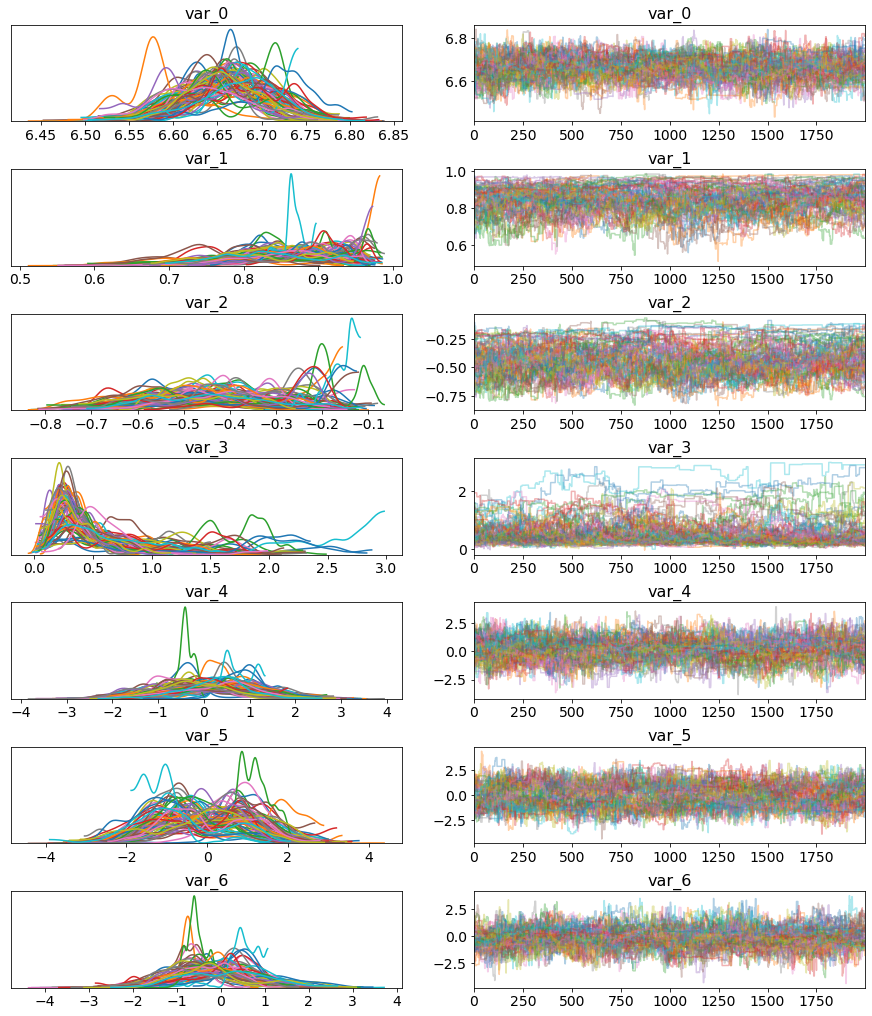

In [14]:
az.plot_trace(tulips)
#               var_names=["ln r", 'ecoseta', 'esineta', 'ln M', 'Lx', 'Ly', 'Lz'])

array([[<AxesSubplot:ylabel='var_1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_3'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_4'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='var_5'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='var_0', ylabel='var_6'>,
        <AxesSubplot:xlabel='var_1'>, <AxesSubplot:xlabel='var_2'>,
        <AxesSubplot:xlabel='var_3'>, <AxesSubplot:xlabel='var_4'>,
        <AxesSubplot:xlabel='var_5'>]], dtype=object)

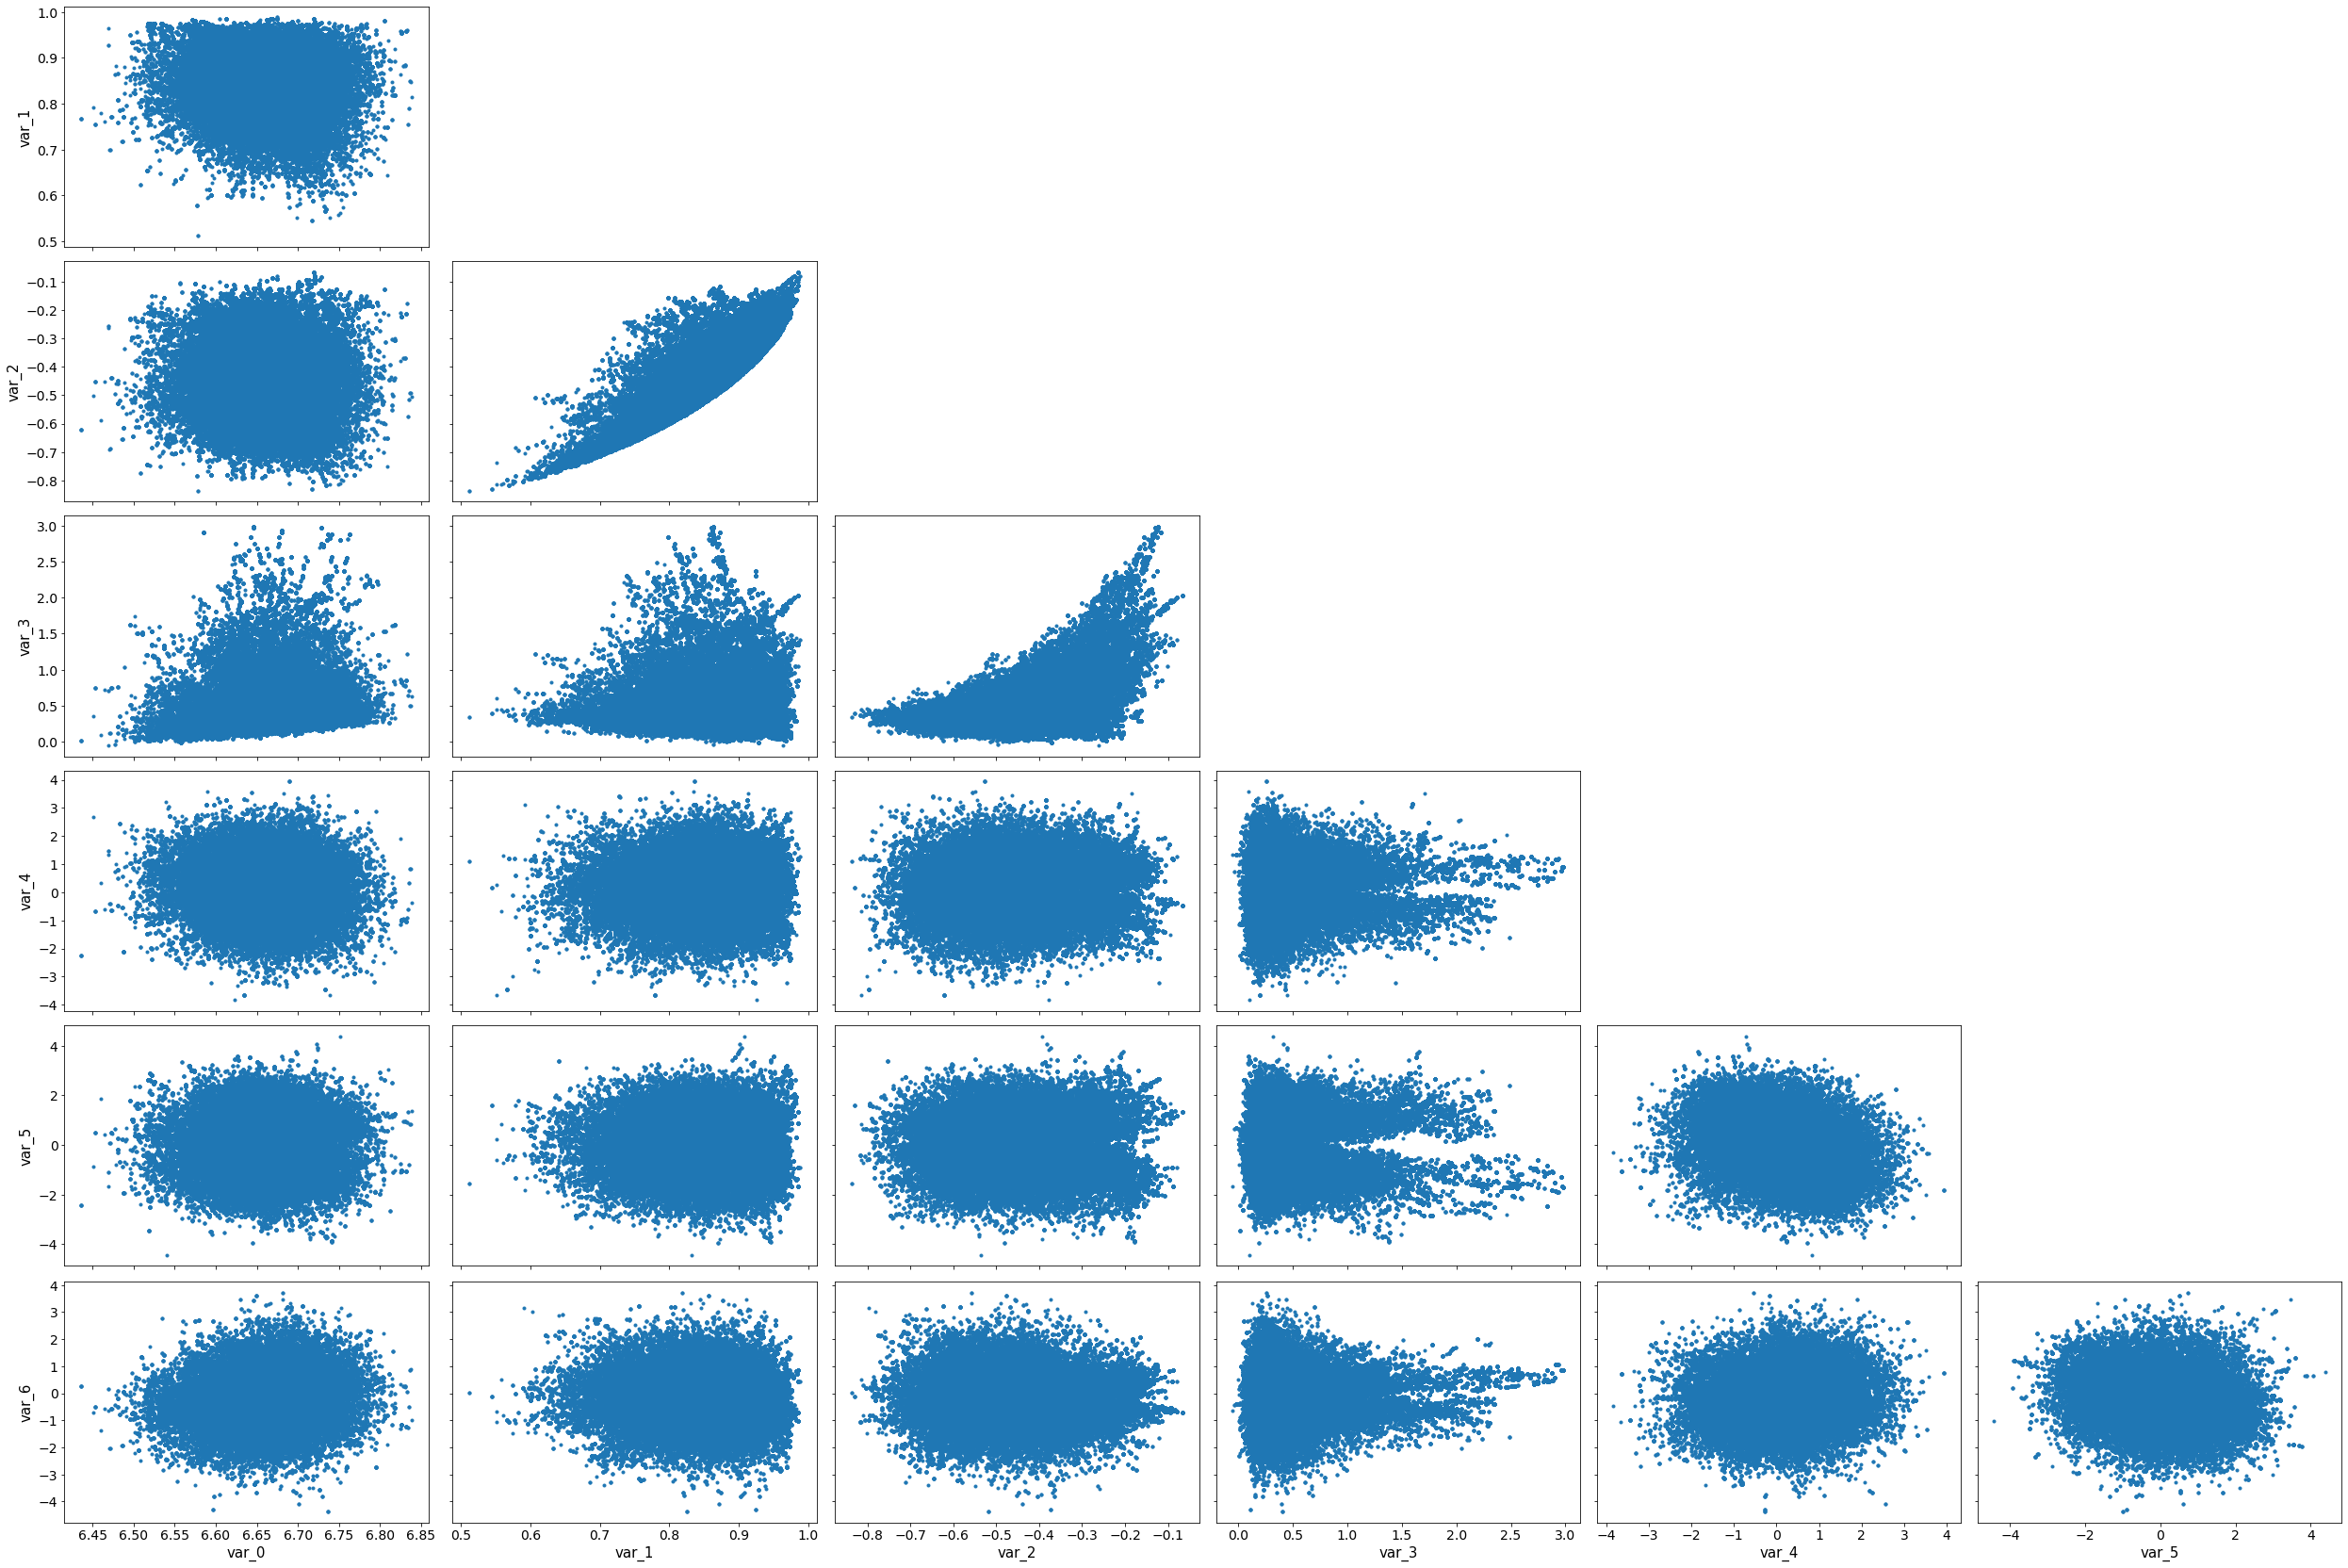

In [15]:
az.plot_pair(tulips)

In [18]:
np.mean(sampler.acceptance_fraction)

0.2576785714285714

In [19]:
np.mean(np.vstack(sampler.chain[:, ::100]), axis=0)

array([ 6.65916728,  0.85186332, -0.42280631,  0.57498377,  0.11761184,
       -0.04898391, -0.24261862])

---

(-3.141592653589793, 3.141592653589793)

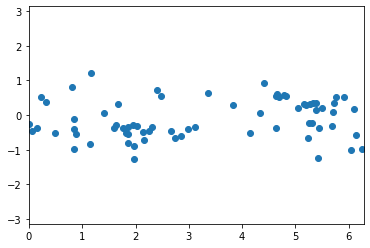

In [20]:
last_pars = model.unpack_pars(sampler.chain[:, -1].T)
last_Lhatlg = coord.CartesianRepresentation(last_pars['Lhatlg'])
last_Lhatlg_sph = last_Lhatlg.represent_as(coord.UnitSphericalRepresentation)
plt.scatter(last_Lhatlg_sph.lon, last_Lhatlg_sph.lat)
plt.xlim(0, 2*np.pi)
plt.ylim(-np.pi, np.pi)